In [2]:
import pandas as pd
import numpy as np
from src.data_collection import deg_utils
import networkx as nx
from src.graph.graph_util import *
from src.graph import RWR
import config.config as config
import copy
from IPython.display import Image, display
import dill
#dill.load_session("03_session.pkl")

# Diffusion analysis

Is it possible to study the effects of the up and down regulated genes over the whole network?

Would this provide meaningful insights? How should the analysis be structured?

**IPOTESI DA TESTARE**: cercare network motifs interessanti come positive/negative feedback loops e bifans nel directed graph una volta buildato. 
Se ad esempio individuo un grande feedback loop, posso farne il functional enrichment e vedere se è legato a una specifica funzione, oltre che a generare ipotesi sulla possibile evoluzione dati i livelli di fold change e propagazione.

To address this, i am going to build a directed graph, including activation/inhibition informations over all the edges and then propagate the fold changes of the seed genes into the network.

https://pmc.ncbi.nlm.nih.gov/articles/PMC8664198/

One possible application of network propagation is the imputation of missing values [2]. For example, shotgun proteomics measurements often do not quantify all proteins in a sample. One might use network propagation to impute those missing values by utilizing measured protein levels of neighboring proteins in the network. In order to test this idea and in order to further validate the plausibility of network propagation results, we imputed expression fold changes (young versus old) for missing proteins and mRNAs with the goal to recover known ageing-associated proteins and transcripts.

To have a gold-standard i can test this hypotesis by keeping the hub nodes for DEG network of old rats used as control, then propagate the fold changes and check wether it matches the ground truth.

In [3]:
deg_df = deg_utils.preprocess_bulk_rna_seq_data(0.05, 0.585, contrast=["group", "302b", "Aging"], file=config.aging_vs_302_PROCESSED_BULK_RNA_SEQ_FILE)  # log2fc of 0.585 corresponds to a 1.5-fold change
downregulated_genes = deg_utils.get_downregulated_genes(deg_df)
upregulated_genes = deg_utils.get_upregulated_genes(deg_df)
print("Downregulated: ", len(downregulated_genes), "Upregulated: ", len(upregulated_genes))
intersection = list(set(downregulated_genes["name"]) & set(upregulated_genes["name"]))
print("Intersection: ", len(intersection))

Downregulated:  835 Upregulated:  518
Intersection:  0


In [4]:
downregulated_graph = get_gene_graph(downregulated_genes.to_dict(orient="records"), config.LIVER_DOWNREGULATED_GRAPH_FILE_NAME)
upregulated_graph = get_gene_graph(upregulated_genes.to_dict(orient="records"), config.LIVER_UPREGULATED_GRAPH_FILE_NAME)

intersection_graph = nx.intersection(downregulated_graph, upregulated_graph)
print("Downregulated Nodes: ", len(downregulated_graph.nodes))
print("Upregulated Nodes: ", len(upregulated_graph.nodes))
print("Intersection Nodes: ", len(intersection_graph.nodes))

Loaded graph '/home/emiliano/Desktop/Università/Network Analysis/Project/Code/data/graphs/liver_downregulated_graph': 6858 nodes, 21862 edges
Loaded graph '/home/emiliano/Desktop/Università/Network Analysis/Project/Code/data/graphs/liver_upregulated_graph': 5871 nodes, 17408 edges
Downregulated Nodes:  6858
Upregulated Nodes:  5871
Intersection Nodes:  3934


In [5]:
directed_combined_graph = nx.compose(downregulated_graph, upregulated_graph)
directed_combined_graph.number_of_nodes(), directed_combined_graph.number_of_edges()

(8795, 32313)

In [6]:
tot_fc = 0
for n, data in directed_combined_graph.nodes(data=True):
    if data["fold_change"] != 0.0:
        tot_fc += 1
print("Number of nodes with non-zero fold change: ", tot_fc)

Number of nodes with non-zero fold change:  1085


### Extract only the large connected component

In [7]:
directed_combined_graph = directed_combined_graph.subgraph(max(nx.connected_components(directed_combined_graph), key=len)).copy()
directed_combined_graph.number_of_nodes(), directed_combined_graph.number_of_edges()

(8408, 32178)

In [8]:
tot_fc = 0
for n, data in directed_combined_graph.nodes(data=True):
    if data["fold_change"] != 0.0:
        tot_fc += 1
print("Number of nodes with non-zero fold change: ", tot_fc)

Number of nodes with non-zero fold change:  783


### Build the signed directed graph

In [9]:
directed_combined_graph = get_directed_graph(directed_combined_graph, config.LIVER_SIGNED_DIRECTED_GRAPH_FILE_NAME)

Loaded graph '/home/emiliano/Desktop/Università/Network Analysis/Project/Code/data/graphs/liver_signed_directed_graph': 8408 nodes, 6274 edges


In [10]:
isolate_nodes = list(nx.isolates(directed_combined_graph))
directed_combined_graph.remove_nodes_from(isolate_nodes)
directed_combined_graph.number_of_nodes(), directed_combined_graph.number_of_edges()

(2521, 6274)

In [11]:
tot_fc = 0
for n, data in directed_combined_graph.nodes(data=True):
    if data["fold_change"] != 0.0:
        tot_fc += 1
print("Number of nodes with non-zero fold change: ", tot_fc)

Number of nodes with non-zero fold change:  177


### Select the SCC subgraph, removing self-loops

In [12]:
scc_graph = nx.strongly_connected_components(directed_combined_graph)
max_scc = set()
for cc in scc_graph:
    if len(cc) > len(max_scc):
        max_scc = cc
scc_combined_graph = directed_combined_graph.subgraph(max_scc).copy()
scc_combined_graph.remove_edges_from(nx.selfloop_edges(scc_combined_graph))
scc_combined_graph.number_of_nodes(), scc_combined_graph.number_of_edges()

(492, 1853)

### Plot statistics and degree distribution

Graph has 492 nodes and 1853 edges.

Degree analysis:
	Average degree: 7.53
	Max degree: 63
	Min degree: 2

Connectedness analysis:
	Number of strongly connected components: 1
	Size of largest strongly connected component: 492
	Is the graph strongly connected? True

Clustering and Density analysis:
	Average clustering coefficient: 0.13705470666886455
	Graph density: 0.00767059096252877


Centrality analysis:
	Average betweenness centrality: 0.008877777428591029
	Max betweenness centrality: 0.2359144712557543
	Min betweenness centrality: 0.0
	Average closeness centrality: 0.1920818589856339
	Max closeness centrality: 0.29757575757575755
	Min closeness centrality: 0.11197263397947549


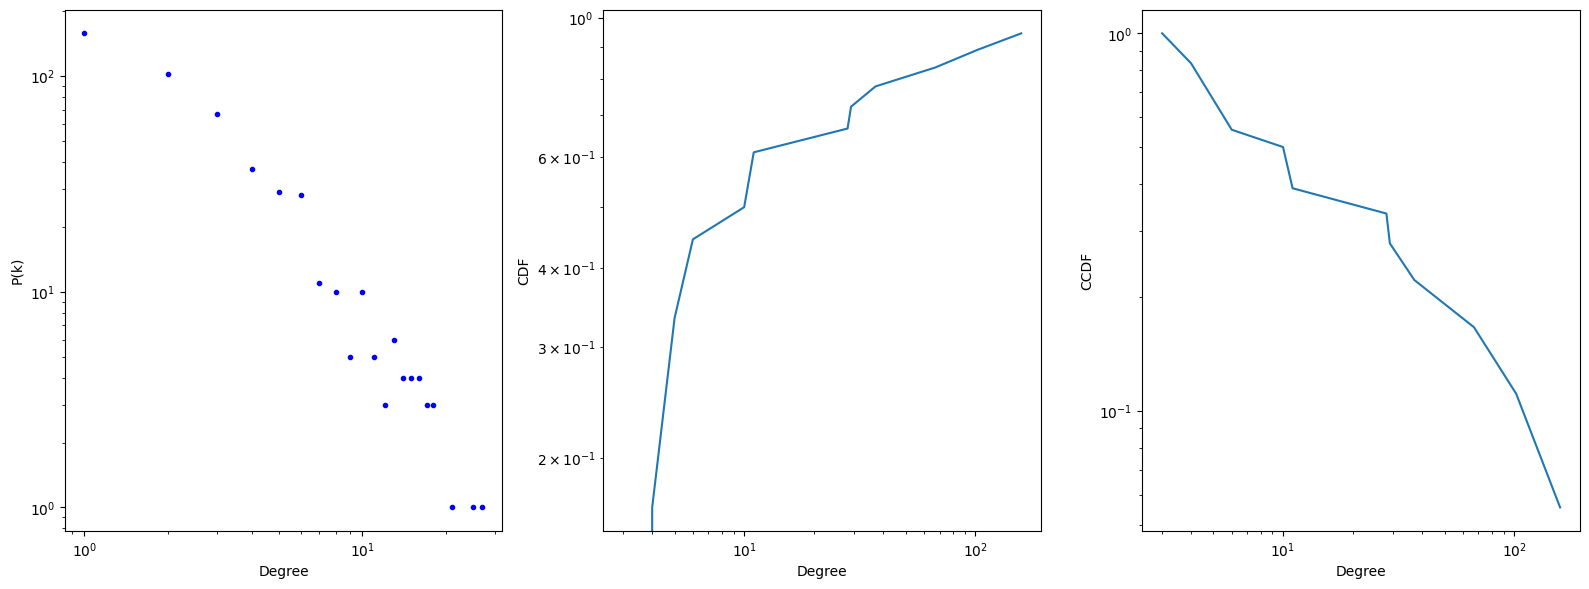

In [13]:
test = print_analysis(scc_combined_graph)
plot_dist(scc_combined_graph)

## Preprocessing

In [14]:
fc_lookup = []
node_lookup = []
for n in scc_combined_graph.nodes():
    fc = scc_combined_graph.nodes[n]["fold_change"]
    fc_lookup.append(fc)
    node_lookup.append(n)

original_fc_vector = pd.Series(fc_lookup)
sum(original_fc_vector.values != 0.0)

np.int64(24)

Number of nodes used for enrichment analysis:  24


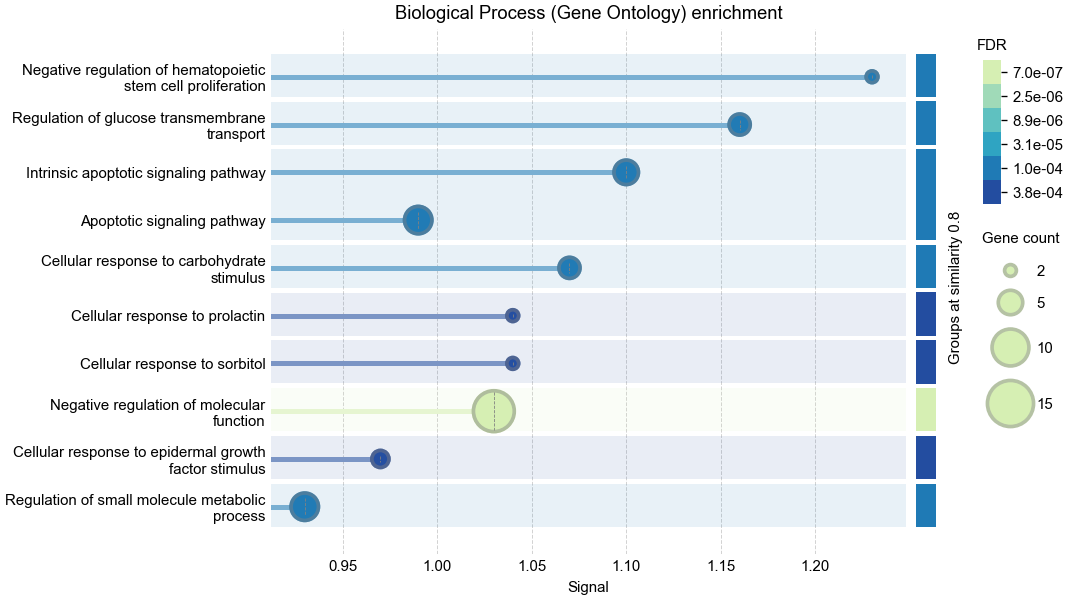

In [15]:
enrich_nodes = []
for n in scc_combined_graph.nodes():
    fc = scc_combined_graph.nodes[n]["fold_change"]
    if fc != 0.0:
        enrich_nodes.append(n)

print("Number of nodes used for enrichment analysis: ", len(enrich_nodes))
enrichment_figure = stringdb_api.get_enrichment_figure(enrich_nodes, ["Process"])
display(Image(data=enrichment_figure))

In [16]:
alphas = [0.2, 0.4, 0.6, 0.76, 0.9]
iters = [20, 50, 100]
A = nx.to_numpy_array(scc_combined_graph, weight="sign")
records = []
for a in alphas:
    for it in iters:
        metrics = RWR.rwr_validate(A, original_fc_vector, a, it, RWR.rwr_diffusion)
        records.append({
            "alpha": a,
            "iter": it,
            "convergence": metrics["convergence"],
            "contrast": metrics["contrast"],
            "stability": metrics["stability"]
        })

df = pd.DataFrame(records)
print(df.sort_values(by="stability", ascending=False))


Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RWR diffusion iterations completed.
Converged.
RW

In [17]:
spreading_coeff = 0.76
n_iter = 100
predicted_fc_vector = RWR.rwr_diffusion(adjacency_matrix=A, fc_vector=original_fc_vector, spreading_coeff=spreading_coeff, n_iter=n_iter)

RWR diffusion iterations completed.


In [18]:
full_inital_degs = pd.read_csv(config.aging_vs_302_PROCESSED_BULK_RNA_SEQ_FILE)
novel_targets = set(node_lookup) - set(list(full_inital_degs["name"].str.upper()))
len(novel_targets)
print(novel_targets)

{'RET', 'IL2', 'CDC25C', 'RIN1', 'MAPK10', 'ILK', 'BMPR1B', 'MC4R', 'LEF1', 'MC2R', 'IL4', 'IFNB1', 'IL10', 'PGR', 'OPRD1', 'TDGF1', 'IL6', 'UBE2V1', 'MC3R', 'GLI1', 'GATA1', 'DCC', 'BARD1', 'SHC3', 'FOXL2', 'POU5F1'}


In [19]:
pred_targets_fc = {}
for tar in novel_targets:
    pred_targets_fc[tar] = predicted_fc_vector[node_lookup.index(tar)]

sorted_pred_targets_fc = dict(sorted(pred_targets_fc.items(), key=lambda item: item[1], reverse=True))
filtered_pred = [pred for pred in sorted_pred_targets_fc.items() if abs(pred[1]) > 0.585]
filtered_pred # 21

[('MC4R', np.float64(25.71759413885994)),
 ('MC2R', np.float64(25.71759413885994)),
 ('MC3R', np.float64(25.71759413885994)),
 ('FOXL2', np.float64(5.6956216625859275)),
 ('BARD1', np.float64(4.535348158259154)),
 ('MAPK10', np.float64(1.5293686601259113)),
 ('BMPR1B', np.float64(0.7742204233729334)),
 ('GATA1', np.float64(0.7391856674870534)),
 ('IL4', np.float64(-0.7006075524661334)),
 ('IL10', np.float64(-0.7333533647102152)),
 ('LEF1', np.float64(-1.1666831626068188)),
 ('IFNB1', np.float64(-1.2131018584712678)),
 ('PGR', np.float64(-1.3038013174795842)),
 ('IL6', np.float64(-1.3331313434321848)),
 ('DCC', np.float64(-2.9286594878280283)),
 ('IL2', np.float64(-3.754450806812679)),
 ('GLI1', np.float64(-5.437402533023772)),
 ('SHC3', np.float64(-5.8882109999270575)),
 ('RET', np.float64(-6.080657457178601)),
 ('RIN1', np.float64(-10.26308784884981)),
 ('OPRD1', np.float64(-56.2580036744607))]